# **Quantum states reconstruction of three-qubit states**

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector


from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit.providers.aer.noise import kraus_error


from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation

In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [5]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

In [6]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [7]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## (In)Fidelity Implementation

In [14]:
#get Bloch vector for 3-qubit states
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])

pauli_basis3q = np.array([np.kron(a,b) for a in pauli_basis2q for b in pauli_basis1q])
pauli_basis3q_modified = pauli_basis3q[1:]


#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis3q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [16]:
I_8 = tf.eye(8, dtype=tf.complex64)


def fid_threeq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis3q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis3q_modified, b)
   rho_a = 0.125 *(el_a + I_8)
   rho_b = 0.125 * (el_b +I_8)
   fidelity = tf.linalg.trace(rho_a @ rho_b) 
   return fidelity     

In [26]:
#Define Infidelity
@tf.function
def infidelity3(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis3q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis3q_modified, b)
   rho_a = 0.125 *(el_a + I_8)
   rho_b = 0.125 * (el_b +I_8)
   fidelity = tf.linalg.trace(rho_a @ rho_b) 
   infidelity = 1 - fidelity
   infidelity = tf.cast(infidelity, dtype = tf.float32)
   return infidelity 

## Noise Model

In [11]:
num_qubits = 1

#PROBABILITIES FOR BIT, PHASE, BIT-PHASE FLIP OR DEPOLARIZING ERRORS
p_error = 0.2
    
#PROBABILITIES FOR GENERAL PAULI ERROR
p_0=0.7
p_1=0.2
p_2=0.05
p_3=0.05
    
#PARAMETERS FOR KRAUS ERROR
alpha = np.pi / 3
beta = np.pi / 6
    
A_0 = np.array([[np.cos (alpha), 0], [0, np.cos (beta)]])
A_1 = np.array([[0, np.sin (beta)], [np.sin (alpha), 0]])
Kraus_operators = [A_0, A_1]
    
bit_flip_error = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip_error = pauli_error([('Z', p_error), ('I', 1 - p_error)])
bit_phase_flip_error = pauli_error([('Y', p_error), ('I', 1 - p_error)])
dep_error = depolarizing_error(p_error, num_qubits)
general_pauli_error = pauli_error([('X', p_1), ('Y', p_2), ('Z', p_3), ('I', p_0)])
AD_error = amplitude_damping_error (0.3, 0.5) 
k_error = kraus_error(Kraus_operators)

In [12]:
#applies error whenever an identity gate appears in the circuit (compatibly with the probability errors)
def qsk_add_error(error_type):
    if error_type == 'bit':
        noise_model.add_all_qubit_quantum_error(bit_flip_error, ["id"])
    if error_type == 'phase':
        noise_model.add_all_qubit_quantum_error(phase_flip_error, ["id"])
    if error_type == 'bit-phase':
        noise_model.add_all_qubit_quantum_error(bit_phase_flip_error, ["id"])
    if error_type == 'depolarizing':
        noise_model.add_all_qubit_quantum_error(dep_error, ["id"])
    if error_type == 'Gpauli':
        noise_model.add_all_qubit_quantum_error(general_pauli_error, ["id"])
    if error_type == 'AD':
        noise_model.add_all_qubit_quantum_error(AD_error, ["id"])
    if error_type == 'Kraus':
        noise_model.add_all_qubit_quantum_error(k_error, ["id"])

## State Reconstruction 

In [13]:
data = generate_Haar_data(3, 2000) 
density_matrix_noise_free = [*map(get_density_matrix, data)] 

In [17]:
num_qubits = 3
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):
    #print(f"Sample: {i+1} / {len(data)}")

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.id(2) #applies identity to the third qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noise_model.add_quantum_error(bit_phase_flip_error, ["id"], [2])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [18]:
bloch_vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]
bloch_vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]

In [19]:
x_train_list = bloch_vectors_with_noise[:1000]
y_train_list = bloch_vectors_noise_free[:1000]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = bloch_vectors_with_noise[1000:1500]
y_val_list = bloch_vectors_noise_free[1000:1500]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = bloch_vectors_with_noise[1500:]
y_test_list = bloch_vectors_noise_free[1500:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

## MSE

In [45]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(63,)),
  tf.keras.layers.Dense(128, activation='relu'), 
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(63)
  ])

In [46]:
# Compile model
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.0002)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [47]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=200, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 1s 62ms/step - loss: 0.1141 - val_loss: 0.1132
Epoch 2/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.1126 - val_loss: 0.1120
Epoch 3/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.1114 - val_loss: 0.1111
Epoch 4/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1105 - val_loss: 0.1104
Epoch 5/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1097 - val_loss: 0.1098
Epoch 6/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.1090 - val_loss: 0.1092
Epoch 7/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1083 - val_loss: 0.1086
Epoch 8/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.1075 - val_loss: 0.1080
Epoch 9/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.1068 - val_loss: 0.1074
Epoch 10/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.1060 - val_loss: 0.1068
Epoch 11/

5/5 [==============================] - 0s 15ms/step - loss: 0.0254 - val_loss: 0.0297
Epoch 84/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0249 - val_loss: 0.0292
Epoch 85/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0244 - val_loss: 0.0287
Epoch 86/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0239 - val_loss: 0.0282
Epoch 87/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0234 - val_loss: 0.0277
Epoch 88/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0230 - val_loss: 0.0272
Epoch 89/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0225 - val_loss: 0.0268
Epoch 90/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0221 - val_loss: 0.0263
Epoch 91/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0217 - val_loss: 0.0258
Epoch 92/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0212 - val_loss: 0.0254
Epoch 93/1000


5/5 [==============================] - 0s 16ms/step - loss: 0.0044 - val_loss: 0.0060
Epoch 165/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0043 - val_loss: 0.0059
Epoch 166/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.0042 - val_loss: 0.0057
Epoch 167/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0040 - val_loss: 0.0056
Epoch 168/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 169/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 170/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0037 - val_loss: 0.0052
Epoch 171/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0036 - val_loss: 0.0051
Epoch 172/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0035 - val_loss: 0.0050
Epoch 173/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch

5/5 [==============================] - 0s 18ms/step - loss: 7.2989e-04 - val_loss: 0.0013
Epoch 245/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.2060e-04 - val_loss: 0.0013
Epoch 246/1000
5/5 [==============================] - 0s 24ms/step - loss: 7.0522e-04 - val_loss: 0.0013
Epoch 247/1000
5/5 [==============================] - 0s 26ms/step - loss: 6.9494e-04 - val_loss: 0.0013
Epoch 248/1000
5/5 [==============================] - 0s 24ms/step - loss: 6.8006e-04 - val_loss: 0.0013
Epoch 249/1000
5/5 [==============================] - 0s 29ms/step - loss: 6.7279e-04 - val_loss: 0.0013
Epoch 250/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.6316e-04 - val_loss: 0.0012
Epoch 251/1000
5/5 [==============================] - 0s 16ms/step - loss: 6.5683e-04 - val_loss: 0.0012
Epoch 252/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.4544e-04 - val_loss: 0.0012
Epoch 253/1000
5/5 [==============================] - 0s 20ms/step - l

5/5 [==============================] - 0s 18ms/step - loss: 2.2730e-04 - val_loss: 5.9901e-04
Epoch 321/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.2374e-04 - val_loss: 5.9586e-04
Epoch 322/1000
5/5 [==============================] - 0s 14ms/step - loss: 2.2257e-04 - val_loss: 5.8905e-04
Epoch 323/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.1960e-04 - val_loss: 5.8773e-04
Epoch 324/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.1634e-04 - val_loss: 5.7873e-04
Epoch 325/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.1276e-04 - val_loss: 5.7254e-04
Epoch 326/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.0867e-04 - val_loss: 5.6803e-04
Epoch 327/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.0505e-04 - val_loss: 5.6493e-04
Epoch 328/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.0237e-04 - val_loss: 5.5925e-04
Epoch 329/1000
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 8.0562e-05 - val_loss: 3.3679e-04
Epoch 396/1000
5/5 [==============================] - 0s 26ms/step - loss: 7.8540e-05 - val_loss: 3.3534e-04
Epoch 397/1000
5/5 [==============================] - 0s 28ms/step - loss: 7.7772e-05 - val_loss: 3.3196e-04
Epoch 398/1000
5/5 [==============================] - 0s 30ms/step - loss: 7.6518e-05 - val_loss: 3.3171e-04
Epoch 399/1000
5/5 [==============================] - 0s 24ms/step - loss: 7.6293e-05 - val_loss: 3.2818e-04
Epoch 400/1000
5/5 [==============================] - 0s 22ms/step - loss: 7.4826e-05 - val_loss: 3.2795e-04
Epoch 401/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.4804e-05 - val_loss: 3.2542e-04
Epoch 402/1000
5/5 [==============================] - 0s 18ms/step - loss: 7.2936e-05 - val_loss: 3.2394e-04
Epoch 403/1000
5/5 [==============================] - 0s 26ms/step - loss: 7.2428e-05 - val_loss: 3.2301e-04
Epoch 404/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 2.9847e-05 - val_loss: 2.2695e-04
Epoch 471/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.9687e-05 - val_loss: 2.2603e-04
Epoch 472/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.9028e-05 - val_loss: 2.2416e-04
Epoch 473/1000
5/5 [==============================] - 0s 21ms/step - loss: 2.9154e-05 - val_loss: 2.2347e-04
Epoch 474/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.8296e-05 - val_loss: 2.2293e-04
Epoch 475/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.8052e-05 - val_loss: 2.2239e-04
Epoch 476/1000
5/5 [==============================] - 0s 19ms/step - loss: 2.7426e-05 - val_loss: 2.2056e-04
Epoch 477/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.7173e-05 - val_loss: 2.1960e-04
Epoch 478/1000
5/5 [==============================] - 0s 17ms/step - loss: 2.6636e-05 - val_loss: 2.1828e-04
Epoch 479/1000
5/5 [==============

5/5 [==============================] - 0s 16ms/step - loss: 1.1867e-05 - val_loss: 1.7438e-04
Epoch 546/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.2164e-05 - val_loss: 1.7392e-04
Epoch 547/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.1838e-05 - val_loss: 1.7353e-04
Epoch 548/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.1524e-05 - val_loss: 1.7213e-04
Epoch 549/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.1008e-05 - val_loss: 1.7209e-04
Epoch 550/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.0829e-05 - val_loss: 1.7114e-04
Epoch 551/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.0510e-05 - val_loss: 1.7037e-04
Epoch 552/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.0619e-05 - val_loss: 1.7100e-04
Epoch 553/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.0755e-05 - val_loss: 1.6977e-04
Epoch 554/1000
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 7.3059e-06 - val_loss: 1.4877e-04
Epoch 621/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.9520e-06 - val_loss: 1.4854e-04
Epoch 622/1000
5/5 [==============================] - 0s 16ms/step - loss: 5.7168e-06 - val_loss: 1.4644e-04
Epoch 623/1000
5/5 [==============================] - 0s 24ms/step - loss: 4.6160e-06 - val_loss: 1.4597e-04
Epoch 624/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.7095e-06 - val_loss: 1.4635e-04
Epoch 625/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.2246e-06 - val_loss: 1.4978e-04
Epoch 626/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.2311e-05 - val_loss: 1.5712e-04
Epoch 627/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.5987e-05 - val_loss: 1.5460e-04
Epoch 628/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.0569e-05 - val_loss: 1.4580e-04
Epoch 629/1000
5/5 [==============

5/5 [==============================] - 0s 26ms/step - loss: 3.6354e-06 - val_loss: 1.3539e-04
Epoch 696/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.6638e-06 - val_loss: 1.3424e-04
Epoch 697/1000
5/5 [==============================] - 0s 24ms/step - loss: 3.9834e-06 - val_loss: 1.3258e-04
Epoch 698/1000
5/5 [==============================] - 0s 16ms/step - loss: 3.2796e-06 - val_loss: 1.3350e-04
Epoch 699/1000
5/5 [==============================] - 0s 16ms/step - loss: 2.7661e-06 - val_loss: 1.3363e-04
Epoch 700/1000
5/5 [==============================] - 0s 31ms/step - loss: 3.0631e-06 - val_loss: 1.3276e-04
Epoch 701/1000
5/5 [==============================] - 0s 26ms/step - loss: 2.4498e-06 - val_loss: 1.3201e-04
Epoch 702/1000
5/5 [==============================] - 0s 26ms/step - loss: 2.1057e-06 - val_loss: 1.3230e-04
Epoch 703/1000
5/5 [==============================] - 0s 26ms/step - loss: 3.3254e-06 - val_loss: 1.3526e-04
Epoch 704/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 5.0583e-06 - val_loss: 1.2845e-04
Epoch 771/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.1608e-06 - val_loss: 1.2626e-04
Epoch 772/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.7489e-06 - val_loss: 1.2502e-04
Epoch 773/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.7695e-06 - val_loss: 1.2943e-04
Epoch 774/1000
5/5 [==============================] - 0s 16ms/step - loss: 7.9180e-06 - val_loss: 1.3243e-04
Epoch 775/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.5244e-06 - val_loss: 1.2654e-04
Epoch 776/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.3570e-06 - val_loss: 1.3259e-04
Epoch 777/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.0191e-05 - val_loss: 1.3372e-04
Epoch 778/1000
5/5 [==============================] - 0s 24ms/step - loss: 8.5563e-06 - val_loss: 1.2819e-04
Epoch 779/1000
5/5 [==============

5/5 [==============================] - 0s 16ms/step - loss: 7.3549e-07 - val_loss: 1.2137e-04
Epoch 846/1000
5/5 [==============================] - 0s 16ms/step - loss: 7.8382e-07 - val_loss: 1.2182e-04
Epoch 847/1000
5/5 [==============================] - 0s 15ms/step - loss: 7.1998e-07 - val_loss: 1.2130e-04
Epoch 848/1000
5/5 [==============================] - 0s 17ms/step - loss: 8.3740e-07 - val_loss: 1.2197e-04
Epoch 849/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.1575e-06 - val_loss: 1.2196e-04
Epoch 850/1000
5/5 [==============================] - 0s 16ms/step - loss: 2.4175e-06 - val_loss: 1.2634e-04
Epoch 851/1000
5/5 [==============================] - 0s 16ms/step - loss: 8.2277e-06 - val_loss: 1.3090e-04
Epoch 852/1000
5/5 [==============================] - 0s 16ms/step - loss: 9.9527e-06 - val_loss: 1.2612e-04
Epoch 853/1000
5/5 [==============================] - 0s 16ms/step - loss: 4.1725e-06 - val_loss: 1.2956e-04
Epoch 854/1000
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 6.4127e-06 - val_loss: 1.2490e-04
Epoch 921/1000
5/5 [==============================] - 0s 16ms/step - loss: 5.2278e-06 - val_loss: 1.2232e-04
Epoch 922/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.0449e-06 - val_loss: 1.2535e-04
Epoch 923/1000
5/5 [==============================] - 0s 24ms/step - loss: 5.9002e-06 - val_loss: 1.2077e-04
Epoch 924/1000
5/5 [==============================] - 0s 16ms/step - loss: 2.0631e-06 - val_loss: 1.2234e-04
Epoch 925/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.6406e-06 - val_loss: 1.1998e-04
Epoch 926/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.1896e-06 - val_loss: 1.2050e-04
Epoch 927/1000
5/5 [==============================] - 0s 20ms/step - loss: 8.5037e-07 - val_loss: 1.1995e-04
Epoch 928/1000
5/5 [==============================] - 0s 16ms/step - loss: 7.2218e-07 - val_loss: 1.1996e-04
Epoch 929/1000
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 3.6713e-06 - val_loss: 1.2008e-04
Epoch 996/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.1377e-06 - val_loss: 1.2087e-04
Epoch 997/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.4409e-06 - val_loss: 1.1951e-04
Epoch 998/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.1620e-06 - val_loss: 1.2159e-04
Epoch 999/1000
5/5 [==============================] - 0s 25ms/step - loss: 1.5447e-06 - val_loss: 1.1934e-04
Epoch 1000/1000
5/5 [==============================] - 0s 16ms/step - loss: 9.0941e-07 - val_loss: 1.1960e-04


In [48]:
score = model.evaluate(x_test,  y_test, verbose=2)

16/16 - 0s - loss: 1.2529e-04 - 188ms/epoch - 12ms/step


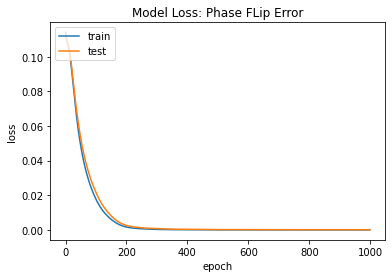

In [49]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_threeq(y_prediction, y_test)
fidn = fid_threeq(y_test, x_test)


print(tf.math.reduce_mean(fid))

tf.Tensor((0.99133-3.2607205e-11j), shape=(), dtype=complex64)


## Infidelity

In [51]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(63,)),                                 
  tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(63),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(7.0) * tf.math.l2_normalize(x, axis=1))
  ])

# Compile model
adam_opt = tf.optimizers.Adam(0.0002)
model.compile(optimizer=adam_opt,
              loss=infidelity3)

In [52]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=200, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 2s 72ms/step - loss: 0.8606 - val_loss: 0.8524
Epoch 2/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.8385 - val_loss: 0.8350
Epoch 3/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.8168 - val_loss: 0.8168
Epoch 4/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.7941 - val_loss: 0.7972
Epoch 5/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.7696 - val_loss: 0.7753
Epoch 6/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.7425 - val_loss: 0.7513
Epoch 7/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.7144 - val_loss: 0.7257
Epoch 8/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.6854 - val_loss: 0.7002
Epoch 9/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.6577 - val_loss: 0.6755
Epoch 10/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.6310 - val_loss: 0.6520
Epoch 11/

5/5 [==============================] - 0s 20ms/step - loss: 0.1333 - val_loss: 0.1845
Epoch 84/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.1312 - val_loss: 0.1820
Epoch 85/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.1292 - val_loss: 0.1797
Epoch 86/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.1272 - val_loss: 0.1773
Epoch 87/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.1252 - val_loss: 0.1752
Epoch 88/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1233 - val_loss: 0.1730
Epoch 89/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1214 - val_loss: 0.1707
Epoch 90/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.1195 - val_loss: 0.1686
Epoch 91/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.1177 - val_loss: 0.1665
Epoch 92/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.1159 - val_loss: 0.1645
Epoch 93/1000


5/5 [==============================] - 0s 18ms/step - loss: 0.0375 - val_loss: 0.0623
Epoch 165/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0370 - val_loss: 0.0616
Epoch 166/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0364 - val_loss: 0.0607
Epoch 167/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0359 - val_loss: 0.0599
Epoch 168/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0353 - val_loss: 0.0591
Epoch 169/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0348 - val_loss: 0.0583
Epoch 170/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0343 - val_loss: 0.0576
Epoch 171/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0338 - val_loss: 0.0568
Epoch 172/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0333 - val_loss: 0.0561
Epoch 173/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0329 - val_loss: 0.0553
Epoch

5/5 [==============================] - 0s 22ms/step - loss: 0.0134 - val_loss: 0.0243
Epoch 246/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0133 - val_loss: 0.0242
Epoch 247/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.0132 - val_loss: 0.0239
Epoch 248/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0130 - val_loss: 0.0236
Epoch 249/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0129 - val_loss: 0.0234
Epoch 250/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0127 - val_loss: 0.0232
Epoch 251/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0126 - val_loss: 0.0229
Epoch 252/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0124 - val_loss: 0.0228
Epoch 253/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0123 - val_loss: 0.0225
Epoch 254/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0122 - val_loss: 0.0222
Epoch

5/5 [==============================] - 0s 18ms/step - loss: 0.0055 - val_loss: 0.0108
Epoch 327/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0054 - val_loss: 0.0107
Epoch 328/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0054 - val_loss: 0.0106
Epoch 329/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0053 - val_loss: 0.0105
Epoch 330/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0052 - val_loss: 0.0104
Epoch 331/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0052 - val_loss: 0.0103
Epoch 332/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 333/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 334/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 335/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch

5/5 [==============================] - 0s 24ms/step - loss: 0.0022 - val_loss: 0.0050
Epoch 408/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0050
Epoch 409/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 410/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0048
Epoch 411/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 412/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 413/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 414/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 415/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 416/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch

5/5 [==============================] - 0s 21ms/step - loss: 8.2322e-04 - val_loss: 0.0025
Epoch 488/1000
5/5 [==============================] - 0s 22ms/step - loss: 8.1369e-04 - val_loss: 0.0025
Epoch 489/1000
5/5 [==============================] - 0s 19ms/step - loss: 8.1109e-04 - val_loss: 0.0025
Epoch 490/1000
5/5 [==============================] - 0s 24ms/step - loss: 7.9643e-04 - val_loss: 0.0025
Epoch 491/1000
5/5 [==============================] - 0s 16ms/step - loss: 7.7786e-04 - val_loss: 0.0025
Epoch 492/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.7921e-04 - val_loss: 0.0025
Epoch 493/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.7428e-04 - val_loss: 0.0024
Epoch 494/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.6690e-04 - val_loss: 0.0024
Epoch 495/1000
5/5 [==============================] - 0s 18ms/step - loss: 7.5641e-04 - val_loss: 0.0024
Epoch 496/1000
5/5 [==============================] - 0s 24ms/step - l

5/5 [==============================] - 0s 20ms/step - loss: 3.1748e-04 - val_loss: 0.0015
Epoch 566/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.1313e-04 - val_loss: 0.0015
Epoch 567/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.0951e-04 - val_loss: 0.0015
Epoch 568/1000
5/5 [==============================] - 0s 24ms/step - loss: 3.1666e-04 - val_loss: 0.0015
Epoch 569/1000
5/5 [==============================] - 0s 16ms/step - loss: 3.0881e-04 - val_loss: 0.0015
Epoch 570/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.0673e-04 - val_loss: 0.0015
Epoch 571/1000
5/5 [==============================] - 0s 28ms/step - loss: 3.0816e-04 - val_loss: 0.0015
Epoch 572/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.0463e-04 - val_loss: 0.0015
Epoch 573/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.9575e-04 - val_loss: 0.0015
Epoch 574/1000
5/5 [==============================] - 0s 18ms/step - l

5/5 [==============================] - 0s 20ms/step - loss: 1.3430e-04 - val_loss: 0.0011
Epoch 644/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.3639e-04 - val_loss: 0.0011
Epoch 645/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.3701e-04 - val_loss: 0.0010
Epoch 646/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.3166e-04 - val_loss: 0.0011
Epoch 647/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.3192e-04 - val_loss: 0.0010
Epoch 648/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.2827e-04 - val_loss: 0.0010
Epoch 649/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.2479e-04 - val_loss: 0.0010
Epoch 650/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.3391e-04 - val_loss: 0.0010
Epoch 651/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.2333e-04 - val_loss: 0.0010
Epoch 652/1000
5/5 [==============================] - 0s 20ms/step - l

Epoch 719/1000
5/5 [==============================] - 0s 19ms/step - loss: 1.7623e-04 - val_loss: 8.5122e-04
Epoch 720/1000
5/5 [==============================] - 0s 22ms/step - loss: 7.8555e-05 - val_loss: 8.3837e-04
Epoch 721/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.8355e-05 - val_loss: 8.2963e-04
Epoch 722/1000
5/5 [==============================] - 0s 22ms/step - loss: 6.6794e-05 - val_loss: 8.3867e-04
Epoch 723/1000
5/5 [==============================] - 0s 24ms/step - loss: 6.3311e-05 - val_loss: 8.3120e-04
Epoch 724/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.6000e-05 - val_loss: 8.3128e-04
Epoch 725/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.3099e-05 - val_loss: 8.2443e-04
Epoch 726/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.2667e-05 - val_loss: 8.2016e-04
Epoch 727/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.8147e-05 - val_loss: 8.3672e-04
Epoch 728/1000
5/5 

5/5 [==============================] - 0s 24ms/step - loss: 4.9549e-05 - val_loss: 7.5229e-04
Epoch 795/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.8969e-05 - val_loss: 7.5015e-04
Epoch 796/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.7793e-05 - val_loss: 7.2634e-04
Epoch 797/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.1832e-05 - val_loss: 7.2306e-04
Epoch 798/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.5541e-05 - val_loss: 7.4733e-04
Epoch 799/1000
5/5 [==============================] - 0s 24ms/step - loss: 5.6297e-05 - val_loss: 7.4439e-04
Epoch 800/1000
5/5 [==============================] - 0s 19ms/step - loss: 5.7663e-05 - val_loss: 7.5383e-04
Epoch 801/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.4926e-05 - val_loss: 7.2475e-04
Epoch 802/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.4457e-05 - val_loss: 7.3153e-04
Epoch 803/1000
5/5 [==============

5/5 [==============================] - 0s 19ms/step - loss: 2.5298e-05 - val_loss: 6.7438e-04
Epoch 870/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.2653e-05 - val_loss: 6.8988e-04
Epoch 871/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.5092e-05 - val_loss: 6.9629e-04
Epoch 872/1000
5/5 [==============================] - 0s 24ms/step - loss: 7.9376e-05 - val_loss: 7.4535e-04
Epoch 873/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.9224e-05 - val_loss: 6.7392e-04
Epoch 874/1000
5/5 [==============================] - 0s 19ms/step - loss: 3.5146e-05 - val_loss: 6.9890e-04
Epoch 875/1000
5/5 [==============================] - 0s 20ms/step - loss: 6.4801e-05 - val_loss: 6.8104e-04
Epoch 876/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.0223e-05 - val_loss: 6.6247e-04
Epoch 877/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.5216e-05 - val_loss: 6.6585e-04
Epoch 878/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 6.3656e-05 - val_loss: 6.3602e-04
Epoch 945/1000
5/5 [==============================] - 0s 21ms/step - loss: 3.8023e-05 - val_loss: 6.5457e-04
Epoch 946/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.2650e-05 - val_loss: 6.3915e-04
Epoch 947/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.5472e-05 - val_loss: 6.5304e-04
Epoch 948/1000
5/5 [==============================] - 0s 25ms/step - loss: 3.5596e-05 - val_loss: 6.7238e-04
Epoch 949/1000
5/5 [==============================] - 0s 16ms/step - loss: 6.6858e-05 - val_loss: 6.8332e-04
Epoch 950/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.9421e-05 - val_loss: 6.3173e-04
Epoch 951/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.5631e-05 - val_loss: 6.4169e-04
Epoch 952/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.9664e-05 - val_loss: 6.5555e-04
Epoch 953/1000
5/5 [==============

In [53]:
score = model.evaluate(x_test,  y_test, verbose=2)

16/16 - 0s - loss: 6.6367e-04 - 243ms/epoch - 15ms/step


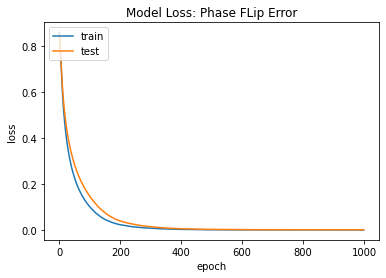

In [54]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_threeq(y_prediction, y_test)
fidn = fid_threeq(y_test, x_test)


print(tf.math.reduce_mean(fid))

tf.Tensor((0.9993363-3.0655065e-10j), shape=(), dtype=complex64)


In [57]:
#comparison
print(y_prediction[2])
print(y_test[2])

[-0.5795257091522217, -0.007430208846926689, -0.2465611845254898, -0.17148642241954803, 0.016766611486673355, -0.2702713906764984, 0.32935336232185364, -0.20797131955623627, 0.23067715764045715, 0.33622097969055176, 0.5676130056381226, -0.5293680429458618, 0.6492822766304016, -0.06707080453634262, 0.25133010745048523, -0.6952028870582581, 0.5918943881988525, 0.045440323650836945, 0.513771653175354, 0.13699105381965637, -0.017199598252773285, 0.38445761799812317, -0.4096710979938507, 0.4627833664417267, -0.1519123613834381, -0.27194851636886597, -0.2948097586631775, 0.6765657067298889, -0.8000011444091797, 0.08293593674898148, -0.13573907315731049, 0.0678432434797287, -0.09236523509025574, 0.11600829660892487, 0.3149227201938629, -0.11136887222528458, 0.34028342366218567, -0.4838319718837738, -0.029407236725091934, 0.35526326298713684, -0.3857245445251465, -0.03757487237453461, 0.19182758033275604, -0.09114466607570648, 0.3614450693130493, 0.2872981131076813, -0.29868775606155396, 0.069